# Homewok n. 2
L'obiettivo di di questo homework è quello di affrontare un problema di clasificazione, cercando di ottenere le migliori prestazioni possibili tra i modelli e le metodologie viste. Il dataset utilizzato è **CIFAR10**, il quale contiene 60000 immagini (di cui 50000 di training e 10000 di test) divise in 10 classi, a risoluzione 32x32 pixel, a colori. 
I requisiti dell'homework sono:
- Caricare il dataset;
- Utilizzare i seguenti modelli di classificazione: regressione logistica, k-NN, SVM, decision tree;
- Effettuare opportunatamente la model selection;
- Riportare le prestazioni ottenute, secondo le metriche di valutazione appropriate.
 

Caricamento delle librerie necessarie allo svolgimento dell'homework:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import  GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

Installazione della libreria Tensorflow

In [2]:
!pip install tensorflow

Carico il dataset **CIFAR10**:

In [3]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Tranining set shape: {X_train.shape}  {y_train.shape}")
print(f"Test set shape: {X_test.shape}  {y_test.shape}")


2025-05-04 09:36:52.307856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746351412.571297      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746351412.645908      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Tranining set shape: (50000, 32, 32, 3)  (50000, 1)
Test set shape: (10000, 32, 32, 3)  (10000, 1)


Preparazione dei dati per l'addestramento:

In [4]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(f"Tranining set reshaped: {X_train.shape}  {y_train.shape}")
print(f"Test set reshaped: {X_test.shape}  {y_test.shape}")

#Convergo i target da 2D a 1D 
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
print(f"Target training set 1D: {y_train.shape}")
print(f"Target test set 1D: {y_test.shape}")

#Standardizzo i dati
scaler = StandardScaler();
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Riduco le dimensioni del dataset con la PCA
n_components = 0.80 #mantengo il 80% della varianza presente nei dati orignali
pca = PCA(n_components)
X_train_red = pca.fit_transform(X_train)
X_test_red = pca.transform(X_test)
print(f"Tranining set PCA: {X_train_red.shape}")
print(f"Test set PCA: {X_test_red.shape}  ")

#Riduco ulteriormente il dataset attraverso lo slicing mantenendo il 20%
perc = 0.2

num_train_red = int(len(X_train_red) * perc)
X_train_red = X_train_red[:num_train_red]
y_train = y_train[:num_train_red]
print(f"Training set reduced: {X_train_red.shape} {y_train.shape}")

Tranining set reshaped: (50000, 3072)  (50000, 1)
Test set reshaped: (10000, 3072)  (10000, 1)
Target training set 1D: (50000,)
Target test set 1D: (10000,)
Tranining set PCA: (50000, 35)
Test set PCA: (10000, 35)  
Training set reduced: (10000, 35) (10000,)


Implemento un algoritmo di grid search utilizzando la classe `GridSearchCV` di `sklearn`,  che mi permette di testare tutte le possibili configurazioni e selezionare la migliore. Per definire le configurazioni da esaminare, utilizzo due dizionari: 
* Il dizionario models ha come chiavi i nomi dei modelli (regressione logistica, k-NN, SVM  decision tree) scritti come stringe. Ogni valore associato a queste chiavi è l'oggetto istanziato del corrispondente modello di classificazione.
* Il dizionario params invece, che presenta le stesse chiavi del dizionario models, associa la relativa griglia di parametri, i quali sono dei dizionari a loro volta.

Best model: SVC(C=10) Best parameters: {'C': 10, 'kernel': 'rbf'}
Classification report:               precision    recall  f1-score   support

           0       0.51      0.54      0.52      1000
           1       0.53      0.55      0.54      1000
           2       0.34      0.40      0.37      1000
           3       0.30      0.29      0.29      1000
           4       0.39      0.36      0.37      1000
           5       0.41      0.34      0.37      1000
           6       0.48      0.56      0.52      1000
           7       0.56      0.48      0.52      1000
           8       0.55      0.60      0.57      1000
           9       0.53      0.47      0.50      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000



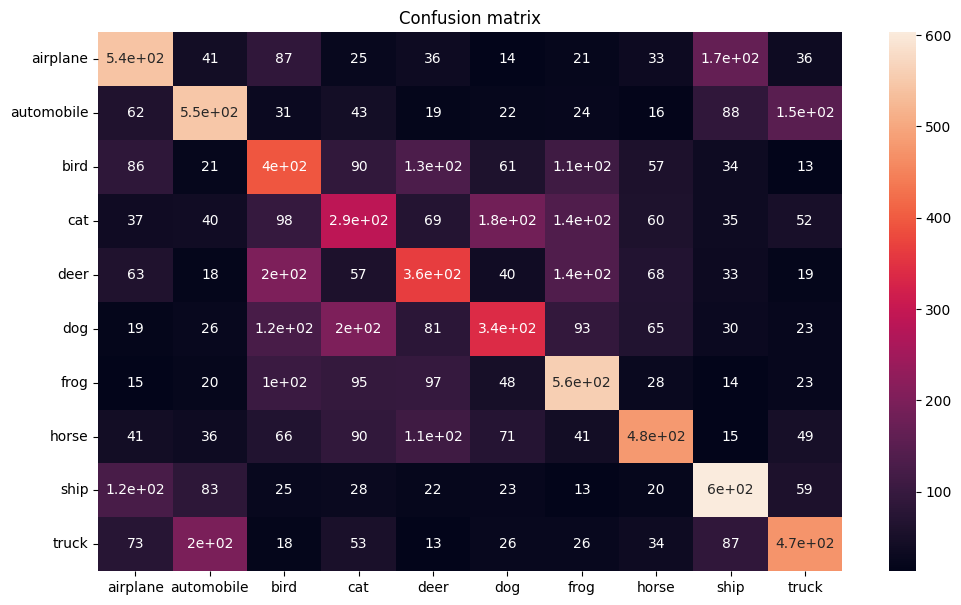

In [6]:
models = {
    "LogisticRegression" : LogisticRegression(),
    "SVM" : SVC(),
    "KNN" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier()
}

params = {
    'LogisticRegression' : { 'max_iter' : [100], 'solver' : ['liblinear'], 'C' : [1.0]},
    "SVM" : {'kernel' :['linear' , 'rbf'], 'C' : [0.01, 0.1, 1, 10] },
    'KNN' : {"metric" : ['euclidean', 'manhattan', 'minkowski', 'cosine'], 'n_neighbors' : list(range(1, 15)) },
    'DecisionTree' : {'max_depth': [3, 4, 5, 6, 7, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'criterion': ['entropy']}
}

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

best_params = None
best_accuracy = 0.0
best_model = None

for model_name in models:
    model = models[model_name]
    param = params[model_name]

    gridsearch = GridSearchCV(model, param, cv = 5, scoring = 'accuracy' )
    gridsearch.fit(X_train_red, y_train)

    if gridsearch.best_score_ > best_accuracy :
        best_accuracy = gridsearch.best_score_
        best_model = gridsearch.best_estimator_
        best_params = gridsearch.best_params_
y_pred = best_model.predict(X_test_red)

print(f"Best model: {best_model} Best parameters: {best_params}")
print(f"Classification report: {classification_report(y_test, y_pred)}")

#Visualizzazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 7))
sns.heatmap(cm, annot = True, xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion matrix")
plt.show()